In [4]:
import klayout.db as pya

# Layers

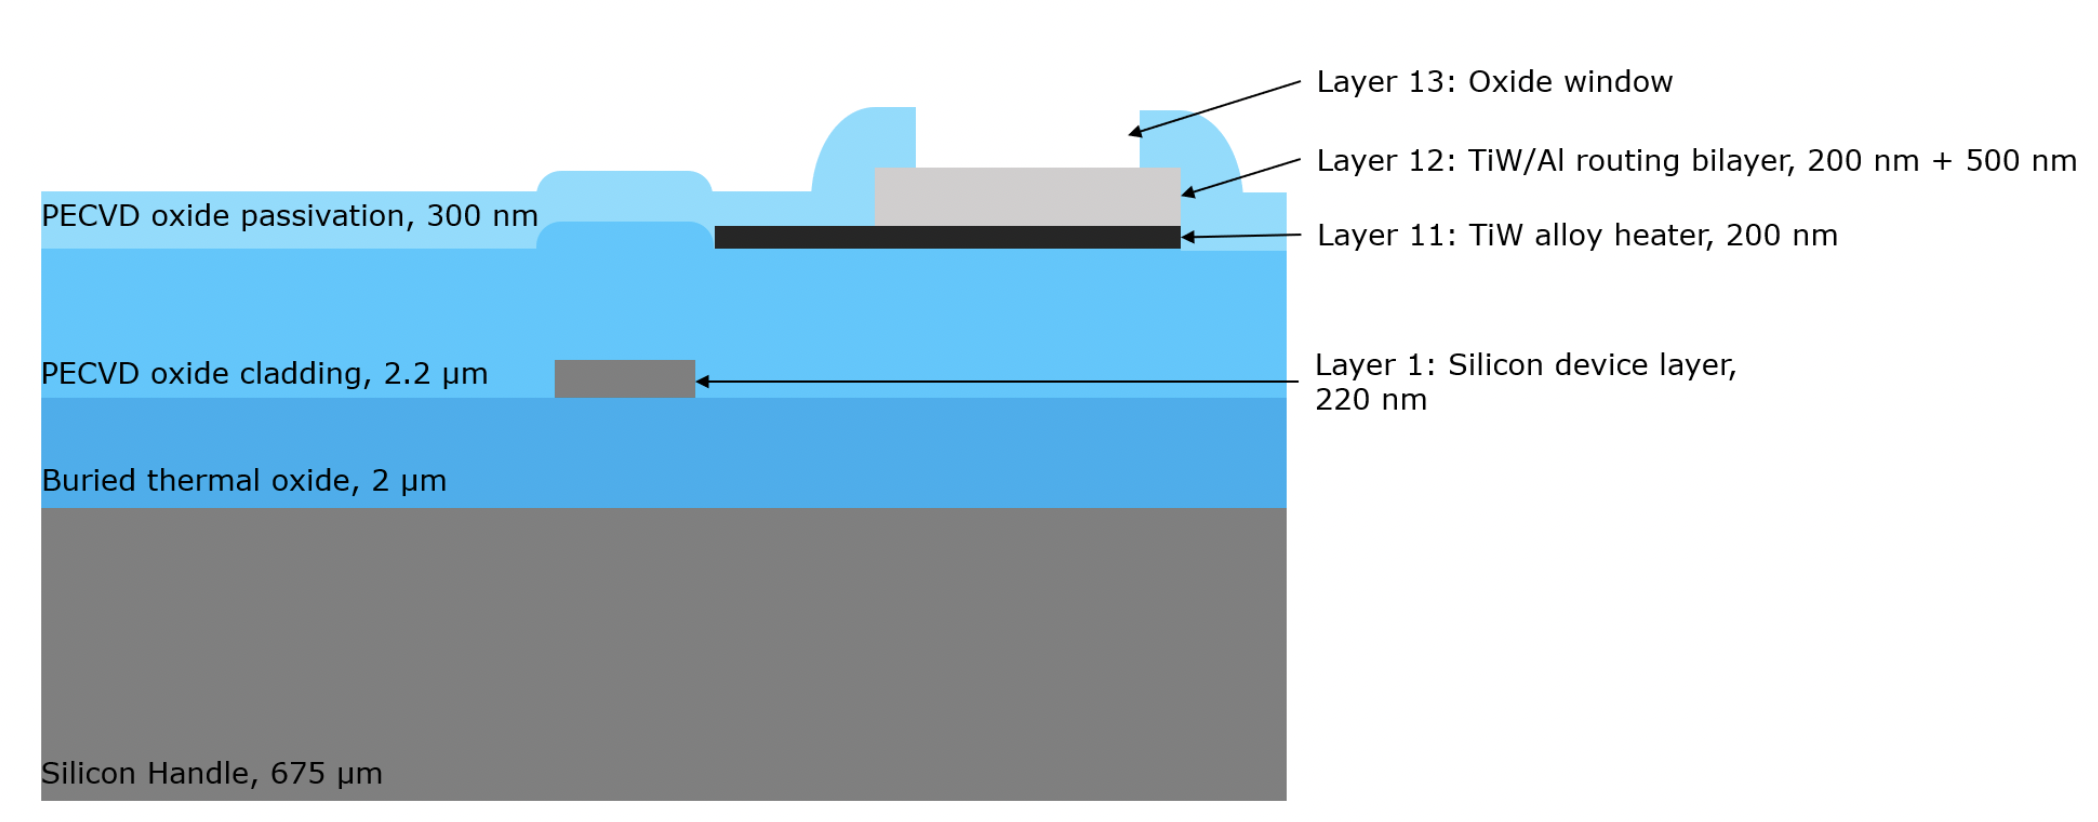

In [5]:
from IPython.display import Image
Image(filename='layers.png', width=600, height=100)

# Importing zeropdk functions we might need

In [6]:
from ebeam_pdk import PDKCell, define_param #programmable cell-- dependent on input parameters (PCell+Ebeam-layers)

from zeropdk.pcell import ParamContainer, place_cell, port_to_pin_helper, Port

from zeropdk.layout.geometry import rotate, rotate90

import numpy as np
from numpy import pi, cos, sin, sqrt

from zeropdk.pcell import (
    TypeDouble,
    TypeInt,
    TypeBoolean,
    TypeString,
    TypeList,
    TypePoint,
    TypeVector,
    TypeLayer,
)

from zeropdk.layout import (
    layout_ring,
    layout_path,
    layout_waveguide,
    layout_circle,
    layout_square,
    layout_arc_with_drc_exclude,
    layout_arc,
    layout_box,
    layout_arc2,
    layout_section,
    layout_donut,
    layout_waveguide_angle,
    layout_waveguide_angle2,
    layout_disk,
    layout_rectangle,
    insert_shape,
    append_relative,
    layout_connect_ports,
    layout_waveguide,
    layout_path_with_ends
)

from zeropdk.layout import box as box_dpolygon


In [7]:
#Define origin, axes for rotation
ex = pya.DVector(1, 0)
ey = pya.DVector(0, 1)
origin = 0 * ex + 0 * ey

# 1st Layout -- microring

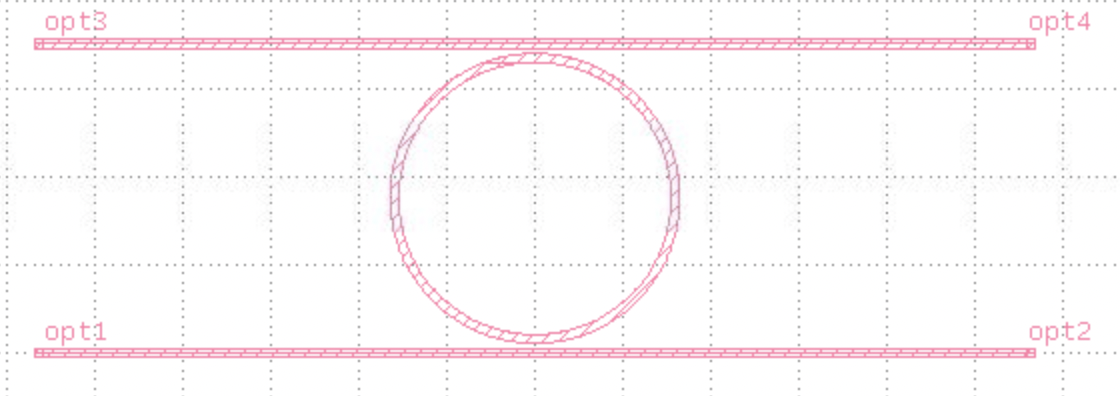

In [5]:
from IPython.display import Image

Image(filename='microring.png', width=600, height=100)

In [8]:
class Microring(PDKCell):

    params = ParamContainer(
        define_param("MRR_radius", TypeDouble, "MRR Radius", default=8),
        define_param("waveguide_width", TypeDouble, "Waveguide width", default=0.5),
        define_param(
            "mod_gap", TypeDouble, "Gap between MRR and main bus waveguide", default=0.3
        ),
        define_param(
            "mod_gap_drop",
            TypeDouble,
            "Gap between MRR and add-drop bus waveguide",
            default=0.3,
        ),
        define_param("layout_ports", TypeBoolean, "layout Pins", default = True),
        define_param("layout_add_drop", TypeBoolean, "Layout add/drop?", default=True),
#         define_param("heater_width", TypeDouble, "Width of Heater", default=2.0),
        )

    def draw(self, cell):
        
        layout = cell.layout()
        cp = self.get_cell_params() #returns object-like parameters. can access cp.radius instead of cp['radius']
        lay = self.get_layers(layout) #retrives layers. allows lay.Si = silicon layer
        
        
        origin, ex, ey = self.origin_ex_ey() #useful for pcell rotation
        
        ring_center = origin 

         # Layout ring
        layout_ring(cell, lay.Si, ring_center, cp.MRR_radius, cp.waveguide_width)
        
        
        
        main_bus_wg_height = cp.MRR_radius + cp.waveguide_width + cp.mod_gap
        drop_bus_wg_height = cp.MRR_radius + cp.waveguide_width + cp.mod_gap_drop
        clearance_padding = 10  #spacing around the microring for the rib box
        taper_length = 10
        port_clearance_from_ring = cp.MRR_radius + taper_length + clearance_padding
        
        
        input_port_position = (
            ring_center - main_bus_wg_height * ey - port_clearance_from_ring * ex
        )
        drop_port_position = (
            ring_center + drop_bus_wg_height * ey - port_clearance_from_ring * ex
        )
        add_port_position = (
            ring_center + drop_bus_wg_height * ey + port_clearance_from_ring * ex
        )
        thru_port_position = (
            ring_center - main_bus_wg_height * ey + port_clearance_from_ring * ex
        )
        
        #layout input bus and drop waveguides
        layout_path(
            cell,
            lay.Si,
            [input_port_position, thru_port_position ],
            cp.waveguide_width,
        )

        # Layout drop waveguide
        if cp.layout_add_drop:
            layout_path(
                cell,
                lay.Si,
                [add_port_position , drop_port_position],
                cp.waveguide_width,
            )
        
        
        ports = []
        
        ports.extend(
                [Port("opt1", input_port_position, -ex, cp.waveguide_width),
                Port("opt2", thru_port_position, ex, cp.waveguide_width),
                Port("opt3", drop_port_position, -ex, cp.waveguide_width),
                Port("opt4", add_port_position, ex, cp.waveguide_width),
                ])

        if cp.layout_ports:
            port_to_pin_helper(ports, cell, lay.PinRec)

        return cell, {port.name: port for port in ports}

In [9]:
# del layout, TOP
layout = pya.Layout()
layout.dbu = 0.001
TOP = layout.create_cell("TOP")

# Write the first GDS

In [13]:
Microring('test_MRR').place_cell(TOP, origin)
layout.write('test_mrr_filter.gds')

# Change the ring parameters and update the layout

In [14]:
del layout, TOP

In [10]:
layout = pya.Layout()
layout.dbu = 0.001
TOP = layout.create_cell("TOP")

In [16]:
Microring('test_MRR', params = {"MRR_radius": 5, "angle_ex":90}).place_cell(TOP, origin)
layout.write('test_mrr_filter.gds')

# Connect two rings

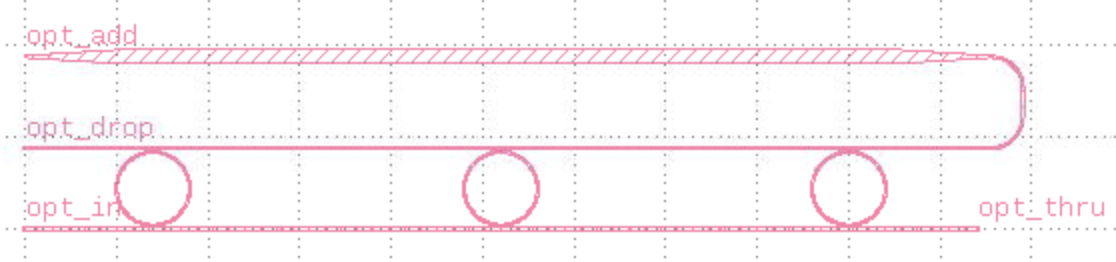

In [11]:
from IPython.display import Image

Image(filename='filter-array.png', width=600, height=100)

In [12]:
from ebeam_pdk import layout_ebeam_waveguide_from_points #draws optical waveguide maintaining the min bend radius


class mrr_filter_bank(Microring):
    
    params = ParamContainer(
        define_param("r_init", TypeDouble, "MRR Initial Radius", default=8),
        define_param("r_delta", TypeDouble, "MRR Delta Radius", default= 0.01213),
        define_param(
            "spacing",
            TypeDouble,
            "Spacing between MRRs (thermal isolation)",
            default=20.000,
        ),
        define_param("N", TypeInt, "Number of MRRs", default=2),
        define_param("layout_ports", TypeBoolean, "Layout Pins?", default=True),
    )
    
    def draw(self, cell):

        layout = cell.layout()
        cp = self.get_cell_params()
        lay = self.get_layers(layout)
        origin, ex, ey = self.origin_ex_ey()
        
        
        cell_ports = [None] * cp.N
        placement_origin = origin

        
        #take microring and place it N times
        for i in range(cp.N):
            cell_ports[i] = Microring(
                f"WBMRR{i}",
                params=cp
                + {
                    "MRR_radius": cp.r_init + i * cp.r_delta,
                    "layout_ports": False,
                    "terminate": False

                },
            ).place_cell(cell, placement_origin, relative_to="opt1")
            placement_origin = cell_ports[i]["opt2"].position + float(cp.spacing) * ex
        
        
        #connect ports of adjacent microrings with a waveguide 
        for i in range(cp.N - 1):
            layout_connect_ports(
                cell, lay.Si, cell_ports[i]["opt4"], cell_ports[i + 1]["opt3"]
            )
            layout_connect_ports(
                cell, lay.Si, cell_ports[i]["opt2"], cell_ports[i + 1]["opt1"]
            )
        
        
        #elongate the waveguide to change the port direction
        Dpath_points = append_relative(
                [cell_ports[cp.N - 1]["opt4"].position], +10 * ex, 20 * ey
            )
        Dpath_points.append(
                Dpath_points[-1] * ey * ey + cell_ports[0]["opt1"].position * ex * ex
            )
        
        layout_ebeam_waveguide_from_points(
                cell, Dpath_points,  radius=7, width=cp.waveguide_width
            )
        
        ports = [Port("opt_add", Dpath_points[-1], -ex, cp.waveguide_width)]
        
        #redefine ports here
        
        ports = [
            cell_ports[0]["opt1"].rename("opt_in"),
            cell_ports[cp.N - 1]["opt2"].rename("opt_thru"),
            cell_ports[0]["opt3"].rename("opt_drop"),
            Port("opt_add", Dpath_points[-1], -ex, cp.waveguide_width)
        ]
        
        if cp.layout_ports:
            port_to_pin_helper(ports, cell, lay.PinRec)
#             insert_shape(cell, lay.DevRec, cell.bbox())

        return cell, {port.name: port for port in ports}


In [13]:
layout = pya.Layout()
layout.dbu = 0.001
TOP = layout.create_cell("TOP")

mrr_filter_bank('test_wb', params = {"N": 4}).place_cell(TOP, origin)

layout.write('test_wb.gds')

# Adding electrical heater

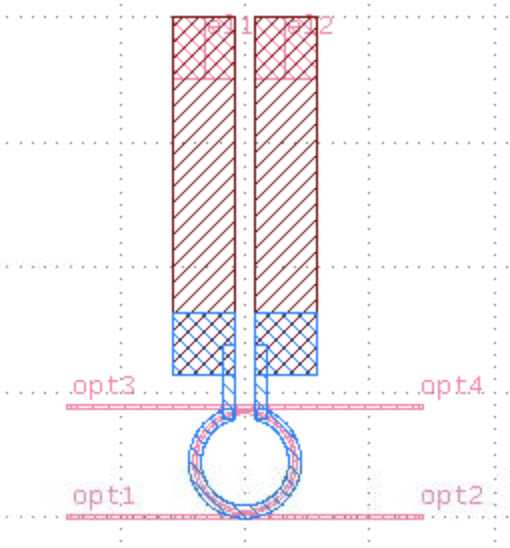

In [14]:
from IPython.display import Image

Image(filename='mrr_heater_cell.png', width=400, height=70)

In [16]:
class Microring_heater(PDKCell):

    params = ParamContainer(
        define_param("MRR_radius", TypeDouble, "Modulator's MRR Radius", default=8),
        define_param("waveguide_width", TypeDouble, "Waveguide width", default=0.5),
        define_param(
            "mod_gap", TypeDouble, "Gap between MRR and main bus waveguide", default=0.3
        ),
        define_param(
            "mod_gap_drop",
            TypeDouble,
            "Gap between MRR and add-drop bus waveguide",
            default=0.3,
        ),
        define_param("layout_ports", TypeBoolean, "layout Pins", default = True),
        define_param("layout_add_drop", TypeBoolean, "Layout add/drop?", default=True),
        define_param("heater_width", TypeDouble, "Width of Heater", default=2.0),

    )

    def draw(self, cell):
        layout = cell.layout()

        cp = self.get_cell_params()
        lay = self.get_layers(layout)
        origin, ex, ey = self.origin_ex_ey()
        
        main_bus_wg_height = cp.MRR_radius + cp.waveguide_width + cp.mod_gap
        drop_bus_wg_height = cp.MRR_radius + cp.waveguide_width + cp.mod_gap_drop

        ring_center = origin + main_bus_wg_height * ey
        # Layout ring
        layout_ring(cell, lay.Si, ring_center, cp.MRR_radius, cp.waveguide_width)
        
        
        clearance_padding = 10  # spacing around the microring for the rib box
        taper_length = 10
        port_clearance_from_ring = cp.MRR_radius + taper_length + clearance_padding
        
        
    
        input_port_position = (
            ring_center - main_bus_wg_height * ey - port_clearance_from_ring * ex
        )
        drop_port_position = (
            ring_center + drop_bus_wg_height * ey - port_clearance_from_ring * ex
        )
        add_port_position = (
            ring_center + drop_bus_wg_height * ey + port_clearance_from_ring * ex
        )
        thru_port_position = (
            ring_center - main_bus_wg_height * ey + port_clearance_from_ring * ex
        )
        
        
        layout_path(
            cell,
            lay.Si,
            [input_port_position - 0.5 * ex, thru_port_position + 0.5 * ex],
            cp.waveguide_width,
        )

        # Layout drop waveguide
        if cp.layout_add_drop:
            layout_path(
                cell,
                lay.Si,
                [add_port_position + 0.5 * ex, drop_port_position - 0.5 * ex],
                cp.waveguide_width,
            )
        
        
        #Drawing a metal heater for routing

        w_mh = cp.heater_width
        r_mh = cp.MRR_radius
        r_mh_in = r_mh - w_mh / 2.0
        angle_min_MH = -255.0 * np.pi / 180.0
        angle_max_MH = 75 * np.pi / 180.0
        elec_port_clearance = 15
        port_width = 10
        
        
        # arc part of heater
        layout_arc(
            cell, lay.M_Heater, ring_center, r_mh, w_mh, angle_min_MH, angle_max_MH, ex
        )
        
        
        heater_box_point_list = [
            [
                (-1.5 - w_mh) * ex + ((r_mh_in) * np.sin(angle_min_MH)) * ey,
                (-1.5) * ex
                + ((drop_bus_wg_height + elec_port_clearance - port_width / 2)) * ey,
            ],
            [
                (1.5) * ex + ((r_mh_in) * sin(angle_min_MH)) * ey,
                (1.5 + w_mh) * ex
                + ((drop_bus_wg_height + elec_port_clearance - port_width / 2)) * ey,
            ],
            [
                -(1.0 * port_width + 1.5) * ex
                + (drop_bus_wg_height + elec_port_clearance - port_width) * ey,
                -1.5 * ex + (drop_bus_wg_height + elec_port_clearance) * ey,
            ],
            [
                1.5 * ex + (drop_bus_wg_height + elec_port_clearance - port_width) * ey,
                (1.0 * port_width + 1.5) * ex
                + (drop_bus_wg_height + elec_port_clearance) * ey,
            ],
        ]
        
        # rectangle part of heater
        for box_points in heater_box_point_list:
            box_dpoly = box_dpolygon(box_points[0], box_points[1], ex, ey)
            box_dpoly.transform_and_rotate(ring_center, ex = None)#pya.DVector(1, 0))
            box_dpoly.layout(cell, lay.M_Heater)
         
        
        metal2_box_point_list = [
            [
                -(1.0 * port_width + 1.5) * ex
                + (drop_bus_wg_height + elec_port_clearance - port_width) * ey,
                -1.5 * ex + 3 * (drop_bus_wg_height + elec_port_clearance) * ey,
            ],
            [
                1.5 * ex + (drop_bus_wg_height + elec_port_clearance - port_width) * ey,
                (1.0 * port_width + 1.5) * ex
                + 3 * (drop_bus_wg_height + elec_port_clearance) * ey,
            ],
        ]
        
        for metal_box_points in metal2_box_point_list:
            metal_box_dpoly = box_dpolygon(
                metal_box_points[0], metal_box_points[1], ex, ey
            )
            metal_box_dpoly.transform_and_rotate(ring_center, None) 
            metal_box_dpoly.layout(cell, lay.ML)
     
        lh_port_position = (
            ring_center
            - (0.5 * port_width + 1.5) * ex
            + (3*(drop_bus_wg_height + elec_port_clearance) - port_width / 2) * ey
        )
        rh_port_position = (
            ring_center
            + (0.5 * port_width + 1.5) * ex
            + (3*(drop_bus_wg_height + elec_port_clearance) - port_width / 2) * ey
        )


        ports = []
        
        ports.extend(
                [Port("opt1", input_port_position, -ex, cp.waveguide_width),
                Port("opt2", thru_port_position, ex, cp.waveguide_width),
                Port("opt3", drop_port_position, -ex, cp.waveguide_width),
                Port("opt4", add_port_position, ex, cp.waveguide_width),
                Port("el1", lh_port_position, ey, port_width),
                Port("el2", rh_port_position, ey, port_width),
                
                ])

        if cp.layout_ports:
            port_to_pin_helper(ports, cell, lay.PinRec)

        return cell, {port.name: port for port in ports}

In [21]:
del TOP, layout

In [22]:
layout = pya.Layout()
layout.dbu = 0.001
TOP = layout.create_cell("TOP")

In [23]:
Microring_heater('test_MRR_heater').place_cell(TOP, origin)
layout.write('test_mrr_heater.gds')

# Experiment -- Electrical routing to contact pads

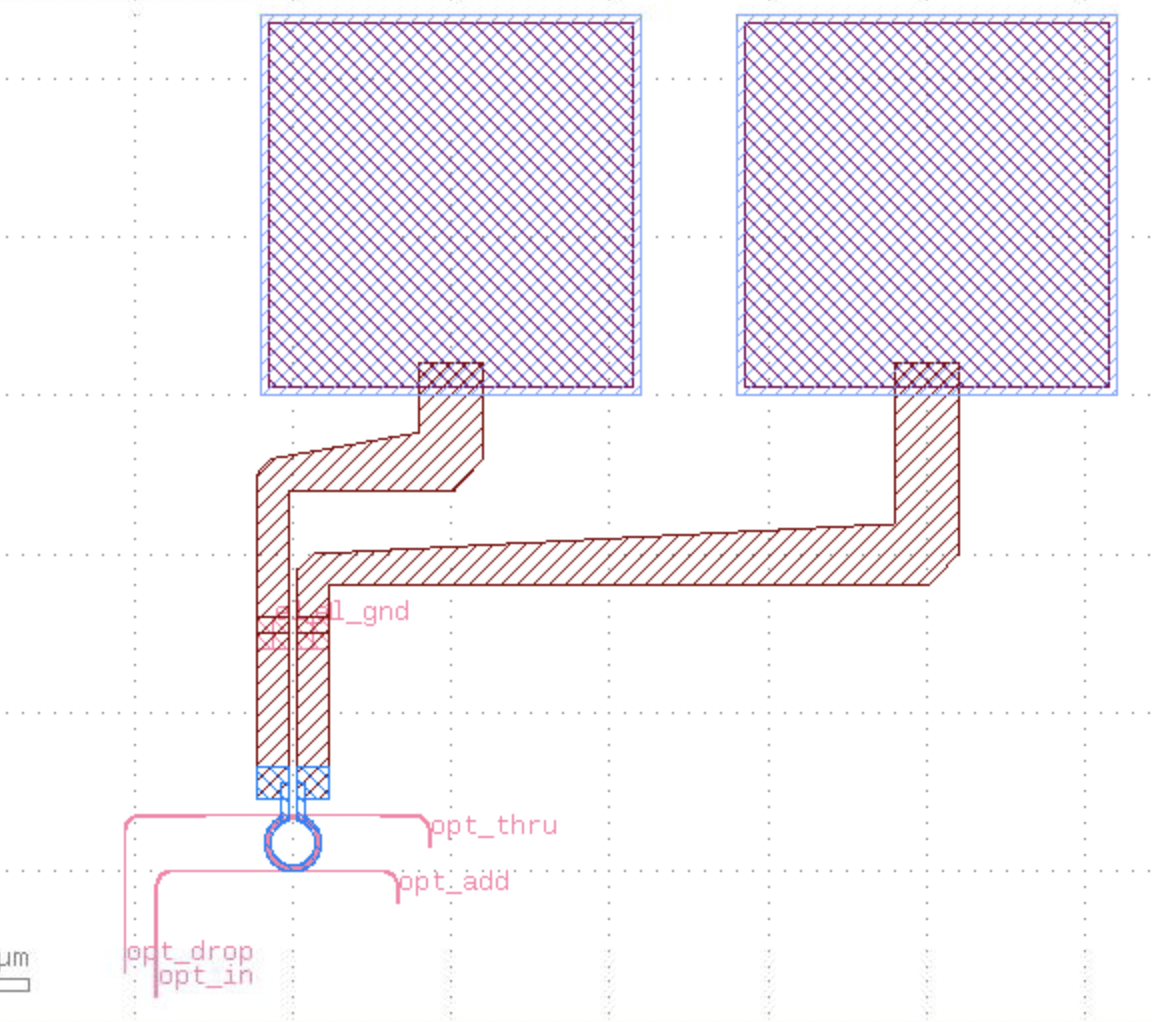

In [12]:
from IPython.display import Image

Image(filename='exp_cell.png', width=400, height=70)

In [36]:
from ebeam_pdk import DCPadArray
from zeropdk.layout.geometry import cluster_ports, manhattan_intersection
from zeropdk.layout.routing import compute_paths_from_clusters, layout_manhattan_traces
from zeropdk.layout.waveguide_rounding import layout_waveguide_from_points 


class test_mrr_exp_cell(Microring_heater, DCPadArray):
     def draw(self, cell):
        layout = cell.layout()

        cp = self.get_cell_params()
        lay = self.get_layers(layout)
        origin, ex, ey = self.origin_ex_ey()

        
        mrr_ports =  Microring_heater("test_mrr_w_heater", params=cp+{"layout_ports":False}).place_cell(cell, origin)
    
        ports = []

        ports.append(
            Port(
                f"el_1",
                mrr_ports["el1"].position ,
                ey,
                mrr_ports["el1"].width,
            )
        )

        ports.append(
            Port(
                f"el_gnd",
                mrr_ports["el2"].position,
                ey,
                mrr_ports["el2"].width,
            )
        )
        cp.pad_array_count = len(ports)
        dc_pad_ports = DCPadArray(
                "dc_pads", params=cp + {"port_width": 20, "angle_ex":0}
            ).place_cell(cell, origin + 150 * ey + 50 * ex)
        
        ports_clusters = cluster_ports(dc_pad_ports.values(), ports, ex)
        
        paths = compute_paths_from_clusters(ports_clusters, lay.ML, ex) 
        
        for path in paths:
            layout_manhattan_traces(cell, path, ex)
        

        #optical routings
        opt_drop = append_relative([mrr_ports["opt3"].position], -25*ex)
        opt_port_loc = append_relative(opt_drop, -50*ey)
        layout_waveguide_from_points(cell, lay.Si, opt_port_loc, 0.5, 5)
        ports.append(
            Port(
                f"opt_drop",
                opt_port_loc[-1],
                -ey,
                mrr_ports["opt3"].width))
        
        opt_in = append_relative([mrr_ports["opt1"].position],-15*ex)
        opt_in_port_loc = append_relative(opt_in, -40*ey)
        layout_waveguide_from_points(cell, lay.Si, opt_in_port_loc, 0.5, 5)
        ports.append(
            Port(
                f"opt_in",
                opt_in_port_loc[-1],
                -ey,
                mrr_ports["opt1"].width))
        
        opt_thru = append_relative([mrr_ports["opt4"].position], 5*ex)
        opt_thru_port_loc = append_relative(opt_thru, 10*ex, -10*ey)
        layout_waveguide_from_points(cell, lay.Si, opt_thru_port_loc, 0.5, 5)
        ports.append(
            Port(
                f"opt_thru",
                opt_thru_port_loc[-1],
                ex,
                mrr_ports["opt4"].width))
        
        opt_drop2 = append_relative([mrr_ports["opt2"].position], 5*ex)
        opt_drop2_port_loc = append_relative(opt_drop2, -10*ey)
        layout_waveguide_from_points(cell, lay.Si, opt_drop2_port_loc, 0.5, 5)
        ports.append(
            Port(
                f"opt_add",
                opt_drop2_port_loc[-1],
                ex,
                mrr_ports["opt4"].width))

        if cp.layout_ports:
            port_to_pin_helper(ports, cell, lay.PinRec)
        # port_to_pin_helper(ports, cell, lay.PinRec)
        # insert_shape(cell, lay.DevRec, cell.bbox())

        return cell, {port.name: port for port in ports}

In [37]:
del TOP, layout

In [38]:
layout = pya.Layout()
layout.dbu = 0.001
TOP = layout.create_cell("TOP")

In [39]:
test_mrr_exp_cell('test_MRR_heater_pads').place_cell(TOP, origin)
layout.write('test_mrr_heater.gds')